In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm

In [61]:
df = pd.read_csv('all_stocks_5yr.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


We only use the close price for the following analysis.
We here expand the stock name as columns names and date as indexes.

In [3]:
close_price = pd.DataFrame(df.date.unique()).rename(columns={0: 'date'}).set_index('date')
for code in tqdm(df.Name.unique()):
    temp = df[df.Name == code][['date', 'close']].set_index('date')
    temp = temp.rename(columns={'close': code})
    close_price = pd.concat([close_price, temp], axis=1)

100%|██████████| 505/505 [00:14<00:00, 36.00it/s]


In [4]:
close_price.head()

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-08,14.75,67.8542,78.90,36.25,46.89,34.41,73.31,39.12,45.70,30.22,...,37.51,28.24,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-11,14.46,68.5614,78.39,35.85,46.76,34.26,73.07,38.64,46.08,30.28,...,37.46,28.31,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,14.27,66.8428,78.60,35.42,46.96,34.30,73.37,38.89,46.27,30.81,...,37.58,28.41,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74
2013-02-13,14.66,66.7156,78.97,35.27,46.64,34.46,73.56,38.81,46.26,31.16,...,37.80,28.42,88.67,43.08,32.00,28.26,64.41,76.00,24.74,33.55
2013-02-14,13.99,66.6556,78.84,36.57,46.77,34.70,73.13,38.61,46.54,31.40,...,38.44,28.22,88.52,42.91,32.12,28.47,63.89,76.34,24.63,33.27


In [66]:
volumes = pd.DataFrame(df.date.unique()).rename(columns={0: 'date'}).set_index('date')
for code in tqdm(df.Name.unique()):
    temp = df[df.Name == code][['date', 'volume']].set_index('date')
    temp = temp.rename(columns={'volume': code})
    volumes = pd.concat([volumes, temp], axis=1)

100%|██████████| 470/470 [00:11<00:00, 39.73it/s]


In [68]:
volumes.head()

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-08,8407500,158168416,1298137,13858795,1232802,10237828,2000477,5104545,2962576,4789484,...,3721016,5390855,11412204,624374,1702218,1206284,7190051,911179,2104483,2599232
2013-02-11,8882000,129029425,758016,6031957,1115888,7928236,1880055,2333712,2382919,4418487,...,2004285,2629693,8764645,422288,1475369,875010,5352531,665462,1839686,1486115
2013-02-12,8126000,151829363,876859,7473991,1318773,7070536,1710274,3279424,2313512,5535196,...,1859525,2321225,9751642,357918,1888523,904935,4934311,1048252,2603143,1637279
2013-02-13,10259500,118721995,1038574,4860053,2645247,6688100,1884631,2490936,2376089,6749912,...,2908631,1537556,8940627,851215,2863447,622205,3999959,931746,2911880,1269625
2013-02-14,31879900,88809154,1005376,7570052,1941879,8561425,2096346,4929645,1991339,7250119,...,4376224,3246492,13238873,759836,1594884,927050,3949356,860104,2789414,2954324


We drop any stock that contains NaN values. These are usually the stocks that were not
a member of the S&P500 for the entire period that we consider.

In [5]:
close_price = close_price[close_price.columns[~close_price.isna().any(axis=0)]]
close_price.shape

(1259, 470)

Take the log of the close prices and compute the difference of the prices on the adjacent days.

In [90]:
Y = np.log(close_price)
DeltaY = Y.diff()[1:]
DeltaY_demeaned = DeltaY - DeltaY.mean()

We plot the histogram of the log returns, and find that the values concentrate in (-0.25, 0.25).

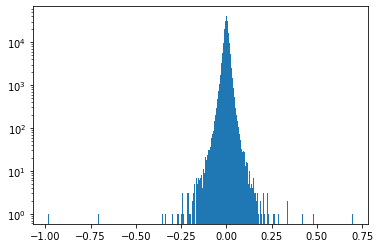

In [8]:
_ = plt.hist(DeltaY.to_numpy().reshape(-1), bins=1000, log=True)

### PCA on the Stock Portfolio

In [13]:
def pca(df):
    f = PCA(n_components=min(df.shape))
    f.fit(df)
    return f

def plot(fitted):
    fig, ax = plt.subplots(1, 2, figsize=(30, 8))
    ax[0].plot(fitted.explained_variance_ratio_)
    ax[1].plot(fitted.explained_variance_ratio_.cumsum())

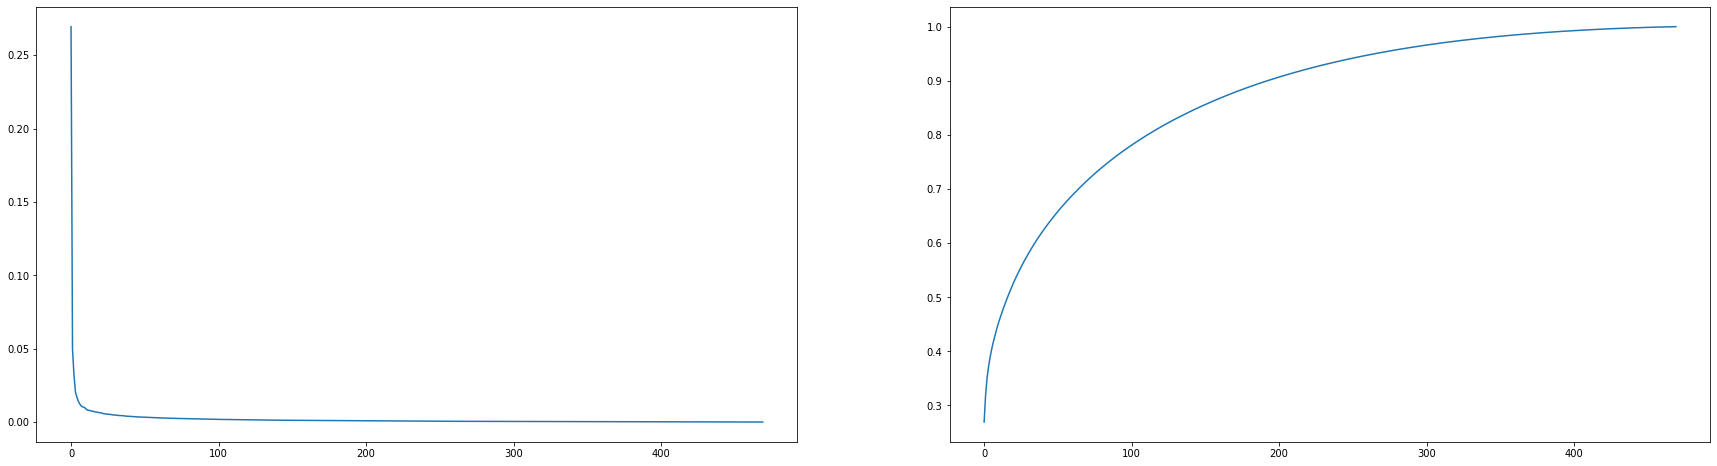

In [14]:
plot(pca(DeltaY))

In [18]:
to_delete = ["LNT"]

In [21]:
non_splitted = ["BBY", "CHK", "EXPE", "FL", "NWL", "PWR", "SIG", "WMB"]
splitted = [x for x in close_price.diff()[DeltaY<-0.3].dropna(how="all").dropna(axis=1, how='all').columns if x not in non_splitted]
delta_splitted = DeltaY[splitted].copy()
temp = delta_splitted[delta_splitted<-0.3].dropna(how="all").dropna(axis=1, how="all")
delta_splitted.update(temp.isna() * temp)

DeltaY_remove_split = DeltaY.copy()
DeltaY_remove_split.update(delta_splitted)
DeltaY_remove_split.drop(columns=to_delete, axis=1, inplace=True)

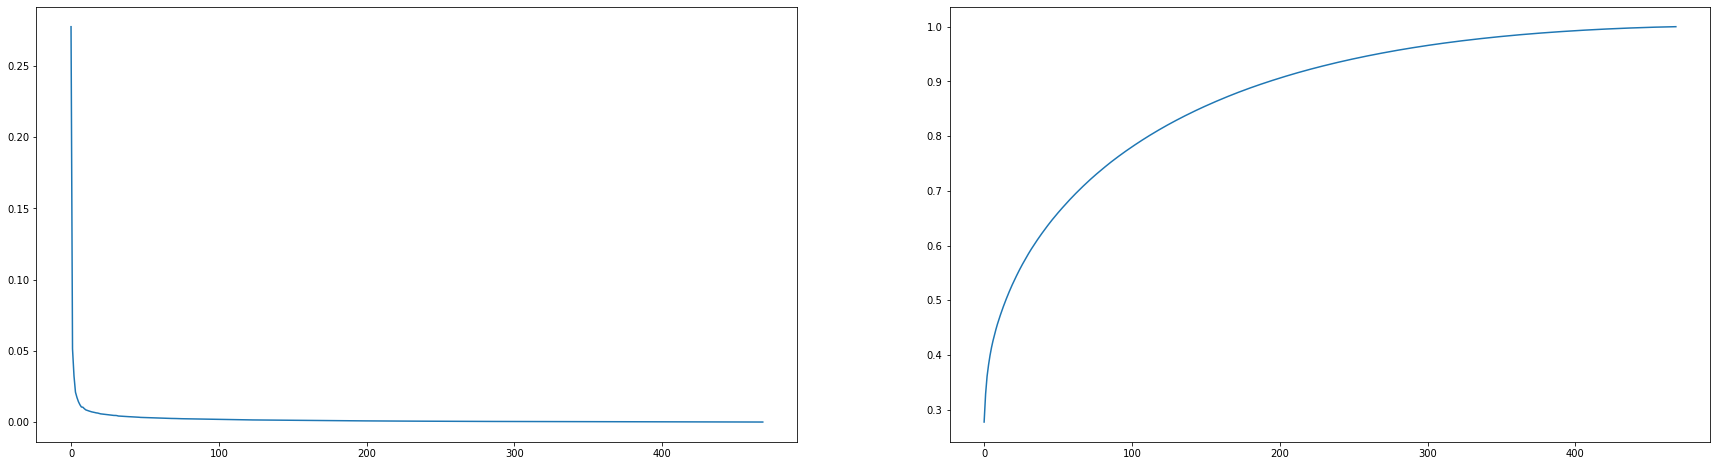

In [24]:
plot(pca(DeltaY_remove_split))

In [218]:
size = len(DeltaY.columns)

In [62]:
df = df[df.Name.isin(DeltaY.columns)]

In [122]:
port_by_vol = df[["volume", "Name"]].groupby("Name").sum().sort_values("volume", ascending=False)[:size]

In [130]:
vol_weights = volumes / volumes.sum(axis=1).to_numpy().reshape(-1, 1)

In [134]:
port_returns_daily = (DeltaY.loc[:, port_by_vol.index] * vol_weights[1:][port_by_vol.index].values)
port_returns = port_returns_daily.sum(axis=1)

In [162]:
abs(port_returns).mean() / abs(port_returns).std()

1.071991336965362

<AxesSubplot:title={'center':'Volume-weighted Portfolio Return'}, xlabel='date'>

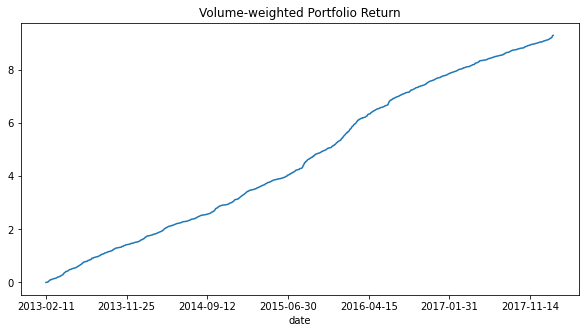

In [169]:
abs(port_returns).cumsum().plot(figsize=(10, 5), title="Volume-weighted Portfolio Return")

In [184]:
def apply_pca(data):
    pca = PCA(n_components=min(data.shape))
    pca.fit(data)
    fig,ax = plt.subplots(1,2,figsize=(30,8))
    ax[0].plot(pca.explained_variance_ratio_[:100], 'x')
    ax[1].plot(pca.explained_variance_ratio_.cumsum()[:100])
    print(pca.explained_variance_ratio_[:10])
    return pca

def get_weights(data, pca, num):
    result = pd.DataFrame([pca.components_[num]])
    result.columns = data.columns
    return result.transpose()

[0.26943977 0.04986343 0.03186521 0.02040738 0.01686886 0.01406797
 0.01218284 0.01091151 0.01028573 0.01002564]


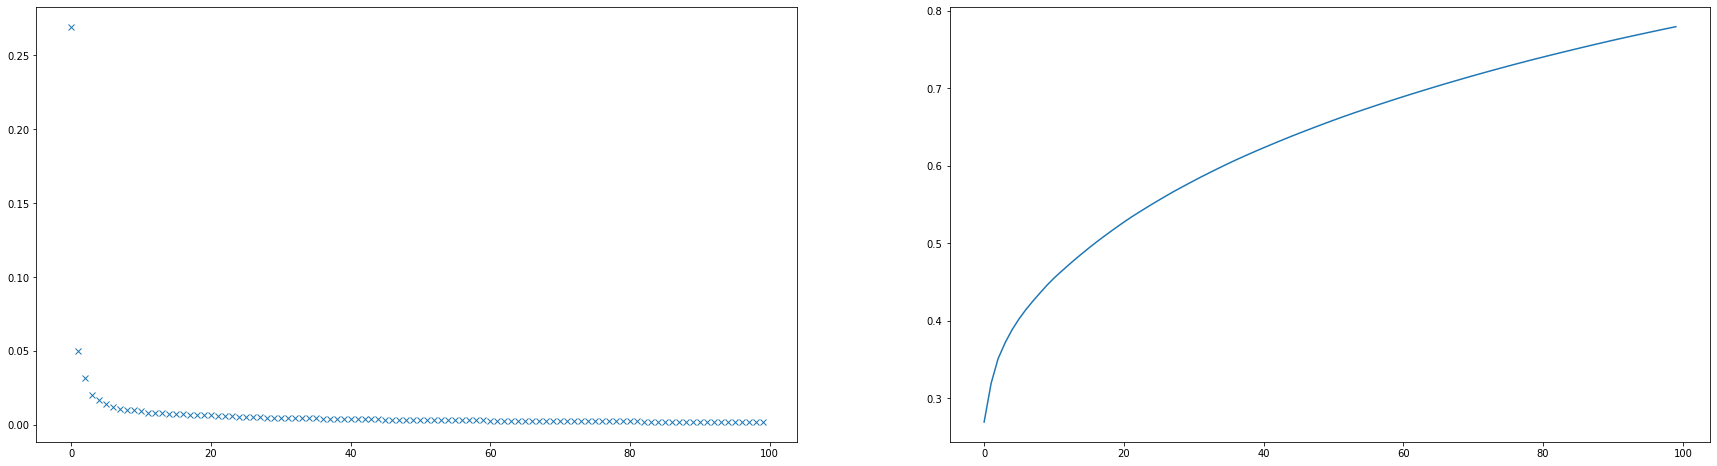

In [185]:
pca = apply_pca(DeltaY_demeaned)

In [214]:
def get_pca_returns(components, volume_weighted=True):
    pca_weights = get_weights(DeltaY_demeaned, pca, 0).loc[port_by_vol.index] 
    for i in range(1, components):
        pca_weights += get_weights(DeltaY_demeaned, pca, i).loc[port_by_vol.index]
    pca_weights = pca_weights / pca_weights.sum()
    if (volume_weighted):
        pca_returns = (port_returns_daily * pca_weights.to_numpy().reshape(-1)).sum(axis=1)
        title = "%s PC and Volume Weighted Portfolio Return" % components
    else:
        pca_returns = (DeltaY.loc[:, port_by_vol.index] * pca_weights.to_numpy().reshape(-1)).sum(axis=1)
        title = "%s PC Weighted Porfolio Return" % components
        
    abs(pca_returns).cumsum().plot(figsize=(10, 5), title=title)
        
    return pca_returns

0.6989989475416815

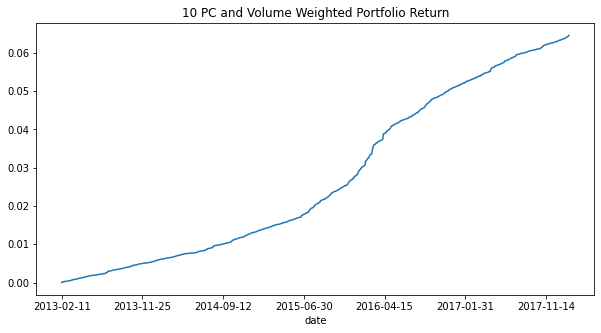

In [215]:
pca_returns = get_pca_returns(10, True)
abs(pca_returns).mean()/abs(pca_returns).std()

1.0273009441619085

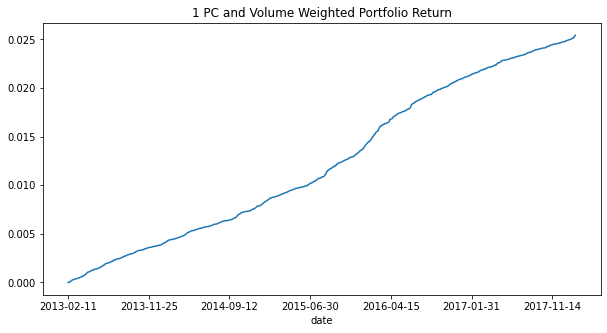

In [217]:
pca_returns = get_pca_returns(1, True)
abs(pca_returns).mean()/abs(pca_returns).std()